<h1><center> COMPUTATIONAL FINANCE - YIELD CURVE BOOTSTRAP</center></h1> 
<h3><center> In this notebook given a set o Treasury Government bonds I will create a yield curve, calculate discount factors, spot and forward rates. I will also explore various methods to bootstrap the yield curve. </center></h3>
<h5><center> Francisco Ramalho </center></h5> 
<h5><center> October 2020 </center></h5> 

-------------------------------------------------------------

## Considering the following bond market information for a set of Treasury government bonds:

| Bond | Coupon rate | Coupon frequency | Maturity (years) | Dirty-price (% of par value)
| :-: | :-: | :-: | :-: | :-: |
| 1 | 1.50% | Annual | 1 | 96.60 |
| 2 | 1.75% | Annual | 2 | 93.71 |
| 3 | 2.00% | Annual | 3 | 91.56 |
| 4 | 2.25% | Annual | 4 | 90.24 |
| 5 | 2.50% | Annual | 5 | 89.74 |
| 6 | 2.75% | Annual | 6 | 90.04 |
| 7 | 3.00% | Annual | 7 | 91.09 |
| 8 | 3.25% | Annual | 8 | 92.82 |
| 9 | 3.50% | Annual | 9 | 95.19 |
| 10 | 3.75% | Annual | 10 | 98.14 |


<h3 style='color:#5F6A6E' > Index:</h3>

<strong >1a.</strong> [Building a class called YieldCurve that will receive an array with information on maturity, price and coupon for n bonds (n x 3)](#section1) <p>
<strong>1b.</strong> [Adding a method that will bootstrap the discount factors using matrix operations](#section2) <p>
<strong>1c.</strong> [Adding a method that will bootstrap the discount factors using a global solver](#section3) <p>
<strong>1d.</strong> [Adding a method that will bootstrap the discount factors using an iterative procedure](#section4) <p>
<strong>2.</strong> [Determining the spot rate (annual compounding) for each maturity from the calculated discount factors and plotting them](#section5)<p>
<strong>3.</strong> [Determining the YTM for each bond and plotting them](#section6) <p>
<strong>4.</strong> [Determining the 1y forward rate starting in each of the years from 1 to 9 and plotting them](#section7) <p>
<strong>5.</strong> [Making a plot of the spot rates, yields and forward rates with a legend identifying the series](#section8) <p>
    

<a id="section1">
<h3 style='color:#5F6A6E' > 1. Building a class called YieldCurve and the 3 different method that will bootstrap the discount factors</h3>
    <a id="section2">
        <a id="section3">
            <a id="section4">

In [1]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

#      bond = [matirity , coupon , price]
data = np.array([(1,0.015,96.6),
                 (2,0.0175,93.71),
                 (3,0.02,91.56),
                 (4,0.0225,90.24),
                 (5,0.025,89.74),
                 (6,0.0275,90.04),
                 (7,0.03,91.09),
                 (8,0.0325,92.82),
                 (9,0.035,95.19),
                 (10,0.0375,98.14)])
data

array([[1.000e+00, 1.500e-02, 9.660e+01],
       [2.000e+00, 1.750e-02, 9.371e+01],
       [3.000e+00, 2.000e-02, 9.156e+01],
       [4.000e+00, 2.250e-02, 9.024e+01],
       [5.000e+00, 2.500e-02, 8.974e+01],
       [6.000e+00, 2.750e-02, 9.004e+01],
       [7.000e+00, 3.000e-02, 9.109e+01],
       [8.000e+00, 3.250e-02, 9.282e+01],
       [9.000e+00, 3.500e-02, 9.519e+01],
       [1.000e+01, 3.750e-02, 9.814e+01]])

In [2]:
# 1a.  
class YieldCurve():
    def __init__(self,C):
        self.maturity = C[:,0]
        self.coupon = C[:,1]
        self.price = C[:,2]


    # assuming that we have a bond for each maturity and bonds pay coupons on the same date, i.e the cashflow matrix is lower triangular
    def CashflowMatrix(self):
        n=len(self.maturity) #matrix dimension
        Matrix=np.tri(n) * self.coupon.reshape(-1,1)*100 + np.eye(n) * 100
        return Matrix

    # method that return each bond in the object
    def Bonds(self):
        return np.array([self.maturity, self.coupon, self.price]).T

# 1b.
    def BootstrapMatrixOperations(self):
        return np.linalg.solve(self.CashflowMatrix(),self.price)   # Ax=B => x = A^-1 . B

    #same method but with matrix operations explicit
    def BootstrapMatrixOperations2(self):
        return np.linalg.inv(self.CashflowMatrix()) @ self.price
    
    
# 1c.
    def BootstrapGlobalSolver(self):
        df_guess=np.zeros(len(self.Bonds()))
        def error(df):
            return np.sum((self.CashflowMatrix() @ df - self.price)**2)
        df=optimize.minimize(error, df_guess)
        return df.x


# 1d.    
    def BootstrapIterative(self):
        df=np.zeros(len(self.Bonds())) #inicializa vector para guardar os DF
        for bond in self.Bonds():
            maturity=int(bond[0])
            coupon=bond[1]
            price=bond[2]
            
            DiscountedCashflows = sum([coupon*df[n] for n in range(maturity -1)])
            f = lambda z : DiscountedCashflows + (1+coupon)*z - price/100 #nos inputs o preco esta definido como percentagem do par value
            zero = optimize.newton(f, 0)
            
            df[int(maturity)-1] = zero
        return df


##### Creating a Yield Curve to test the class and methods created:

In [3]:
GovernmentBonds=YieldCurve(data)
GovernmentBonds

In [4]:
GovernmentBonds.Bonds()

array([[1.000e+00, 1.500e-02, 9.660e+01],
       [2.000e+00, 1.750e-02, 9.371e+01],
       [3.000e+00, 2.000e-02, 9.156e+01],
       [4.000e+00, 2.250e-02, 9.024e+01],
       [5.000e+00, 2.500e-02, 8.974e+01],
       [6.000e+00, 2.750e-02, 9.004e+01],
       [7.000e+00, 3.000e-02, 9.109e+01],
       [8.000e+00, 3.250e-02, 9.282e+01],
       [9.000e+00, 3.500e-02, 9.519e+01],
       [1.000e+01, 3.750e-02, 9.814e+01]])

In [5]:
GovernmentBonds.CashflowMatrix()

array([[101.5 ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ],
       [  1.75, 101.75,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ],
       [  2.  ,   2.  , 102.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ],
       [  2.25,   2.25,   2.25, 102.25,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ],
       [  2.5 ,   2.5 ,   2.5 ,   2.5 , 102.5 ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ],
       [  2.75,   2.75,   2.75,   2.75,   2.75, 102.75,   0.  ,   0.  ,
          0.  ,   0.  ],
       [  3.  ,   3.  ,   3.  ,   3.  ,   3.  ,   3.  , 103.  ,   0.  ,
          0.  ,   0.  ],
       [  3.25,   3.25,   3.25,   3.25,   3.25,   3.25,   3.25, 103.25,
          0.  ,   0.  ],
       [  3.5 ,   3.5 ,   3.5 ,   3.5 ,   3.5 ,   3.5 ,   3.5 ,   3.5 ,
        103.5 ,   0.  ],
       [  3.75,   3.75,   3.75,   3.75,   3.75,   3.75,   3.75,   3.75,
          3.75, 103.75]])

In [6]:
GovernmentBonds.BootstrapMatrixOperations()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

In [7]:
GovernmentBonds.BootstrapMatrixOperations2()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

In [8]:
GovernmentBonds.BootstrapGlobalSolver()

array([0.95172414, 0.90461408, 0.86124827, 0.82274259, 0.7891627 ,
       0.76042722, 0.73611886, 0.71559687, 0.69849544, 0.68423625])

In [9]:
GovernmentBonds.BootstrapIterative()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

##### Bootstrapping the yield curve with the 3 methods created resulted in the same discount factors as expected

<a id="section5">
<h3 style='color:#5F6A6E' > 2. Determining the spot rate (annual compounding) for each maturity from the calculated discount factors and plotting them</h3>

Knowing that:

$DiscountFactor = \frac{1}{(1+SpotRate)^t}$
 
we have that:

$SpotRate = \sqrt[t]{1/DF} - 1$

In [10]:
TimeFactor=1/GovernmentBonds.maturity
InverseDF=1/GovernmentBonds.BootstrapMatrixOperations()
SpotRateCurve = np.power(InverseDF, TimeFactor)-1 
SpotRateCurve

array([0.05072464, 0.05140086, 0.05105122, 0.0499872 , 0.04849579,
       0.04670361, 0.04473811, 0.04271698, 0.04067509, 0.03867431])

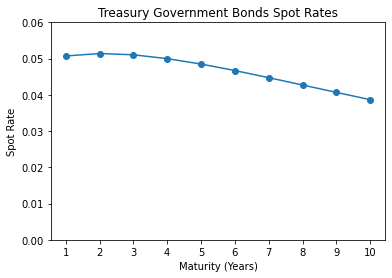

In [11]:
fig1, ax1 = plt.subplots()
ax1.plot(GovernmentBonds.maturity,SpotRateCurve,marker='o');
ax1.set_title("Treasury Government Bonds Spot Rates");
ax1.set_xlabel('Maturity (Years)');
ax1.set_ylabel('Spot Rate');
ax1.set_xticks(GovernmentBonds.maturity);
ax1.set_yticks(np.linspace(0,0.06,7));

<a id="section6">
<h3 style='color:#5F6A6E' > 3. Determining the YTM for each bond and plotting them</h3>

In [12]:
def YTM(maturity, coupon, price):
    ytm_func = lambda y : sum([(coupon if n < maturity else coupon + 1)/(1+y)**n
                              for n in range(1, maturity +1)]) * 100 - price
    return optimize.newton(ytm_func, 0)

YieldsToMaturity=np.empty(0)
for bond in GovernmentBonds.Bonds():
    a=bond
    YieldsToMaturity=np.append(YieldsToMaturity,YTM(int(a[0]),a[1],a[2]))
    
YieldsToMaturity

array([0.05072464, 0.0513948 , 0.05105361, 0.05002602, 0.04860682,
       0.04693075, 0.04512745, 0.04331056, 0.04151381, 0.03979082])

As all the bonds have the same periods between payments, we could have used the Internal Rate Return function:

In [13]:
import numpy_financial as npf
MatrixPricesCasflows=np.insert(GovernmentBonds.CashflowMatrix(),0,-GovernmentBonds.price,axis=1)   
YieldsToMaturity2=np.apply_along_axis(npf.irr,1,MatrixPricesCasflows)
YieldsToMaturity2

array([0.05072464, 0.0513948 , 0.05105361, 0.05002602, 0.04860682,
       0.04693075, 0.04512745, 0.04331056, 0.04151381, 0.03979082])

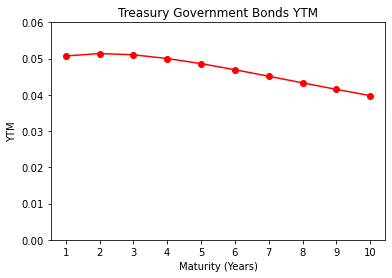

In [14]:
fig2, ax2 = plt.subplots()
ax2.plot(GovernmentBonds.maturity,YieldsToMaturity,marker='o',color='r');
ax2.set_title("Treasury Government Bonds YTM");
ax2.set_xlabel('Maturity (Years)');
ax2.set_ylabel('YTM');
ax2.set_xticks(GovernmentBonds.maturity);
ax2.set_yticks(np.linspace(0,0.06,7));

<a id="section7">
<h3 style='color:#5F6A6E' > 4. Determining the 1y forward rate starting in each of the years from 1 to 9 and plotting them</h3>

Knowing that:

${(1+SpotRate_{t_2})^{t_2}} = {(1+SpotRate_{t_1})^{t_1}} {(1+ForwardRate)^{t_2-t_1}}$

we have that:

$ForwardRate = (\frac{(1+SpotRate_{t_2})^{t_2}}{(1+SpotRate_{t_1})^{t_1}})^{\frac{1}{t_2-t_1}}$

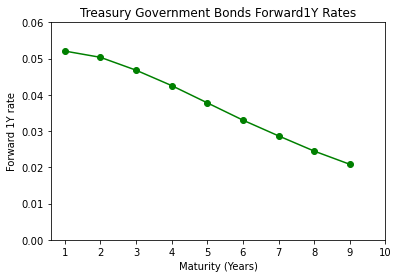

In [15]:
def ForwardRate (zero1,zero2,tenor1,tenor2):
    return (((1+zero2)**tenor2)/((1+zero1)**tenor1))**(1/(tenor2-tenor1))-1

ForwardRatesArray=np.empty(0)
for i in range(len(GovernmentBonds.Bonds())-1):
    ForwardRatesArray=np.append(ForwardRatesArray,ForwardRate(SpotRateCurve[i],SpotRateCurve[i+1],GovernmentBonds.maturity[i],GovernmentBonds.maturity[i+1]))

fig3, ax3 = plt.subplots()
ax3.plot(GovernmentBonds.maturity[:len(GovernmentBonds.Bonds())-1],ForwardRatesArray,marker='o',color='g',label="Forward 1Y Rates")
ax3.set_title("Treasury Government Bonds Forward1Y Rates");
ax3.set_xlabel('Maturity (Years)');
ax3.set_ylabel('Forward 1Y rate');
ax3.set_xticks(GovernmentBonds.maturity);
ax3.set_yticks(np.linspace(0,0.06,7));

In [16]:
ForwardRatesArray

array([0.05207752, 0.05035228, 0.04680161, 0.04255129, 0.0377886 ,
       0.03302233, 0.02867815, 0.02448323, 0.02083956])

<a id="section8">
<h3 style='color:#5F6A6E' > 5. Making a plot of the spot rates, yields and forward rates with a legend identifying the series</h3>

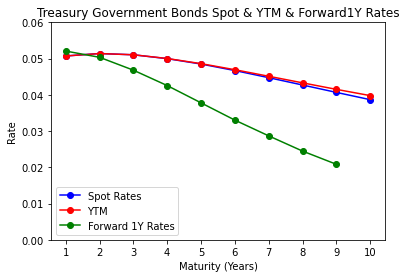

In [17]:
fig4, ax4 = plt.subplots()
ax4.plot(GovernmentBonds.maturity,SpotRateCurve,marker='o',color='b',label="Spot Rates");
ax4.plot(GovernmentBonds.maturity,YieldsToMaturity,marker='o',color='r',label="YTM");
ax4.plot(GovernmentBonds.maturity[:len(GovernmentBonds.Bonds())-1],ForwardRatesArray,marker='o',color='g',label="Forward 1Y Rates");
ax4.set_title("Treasury Government Bonds Spot & YTM & Forward1Y Rates");
ax4.set_xlabel('Maturity (Years)');
ax4.set_ylabel('Rate');
ax4.set_xticks(GovernmentBonds.maturity);
ax4.legend();
ax4.set_yticks(np.linspace(0,0.06,7));